### Esercitazione 23 - Modelli Predittivi Simple Exponential Smoothing, Holt's Linear Trend e Holt-Winters Seasonal Method

Il modello più appropriato per effettuare predizioni su serie temporali di dati dipende principalmente dalla tipologia
di dati che si hanno a disposizione.
Tra le diverse tipologie di modelli predittivi esistenti, in questo notebook analizziamo 3 semplici modelli,
implementati e disponibili nella libreria **statsmodel** di Python.

* **Simple Exponential Smoothing** (SES) dati senza trend o stagionalità
* **Holt’s Linear Trend Method** dati con trend ma senza stagionalità
* **Holt-Winters’ Seasonal Method** dati con trend e/o stagionalità

In [1]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import matplotlib.pyplot as plt
from Historic_Crypto import HistoricalData
from datetime import datetime, timedelta

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=180)
candles = HistoricalData(
    ticker='ETH-EUR',
    granularity=3600 * 24,
    start_date=start_date.strftime('%Y-%m-%d-%H-%M'),
    end_date=end_date.strftime('%Y-%m-%d-%H-%M'),
    verbose=False
).retrieve_data()

In [3]:
candles['tp'] = (candles.high + candles.close + candles.low) / 3

split_date = candles.index[-1] - timedelta(days=10)

candles_train = candles[:split_date].tp
candles_test = candles[split_date:].tp
predict_date = len(candles) - len(candles_train)

### Simple Exponential Smoothing

Simple Exponential Smoothing è un modello che effettua previsioni utilizzando semplicemente
medie ponderate. Un parametro importante utilizzato da questo modello è il parametro di
livellamento: α, che può assumere un valore compreso tra 0 e 1 e serve per determinare il
livello di livellamento.
Quando α=0, le previsioni sono pari alla media dei dati storici.
Quando α=1, le previsioni saranno pari al valore dell'ultima osservazione.

SES prevede una linea piatta poiché la sua logica alla base utilizza medie ponderate.
Anche se l'errore finale è basso, non è in grado di prevedere alcuna fluttuazione.
Poiché la maggior parte dei dati delle serie temporali ha delle componenti di trend e/o
stagionalità, questo modello predittivo può essere utilizzato per avere un'idea di una
linea di base per il confronto di ulteriori modelli / strategie.

--- Simple Exponential Smoothing ---

Errore con livello di smussamento custom di 0.8 = 14.75


c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


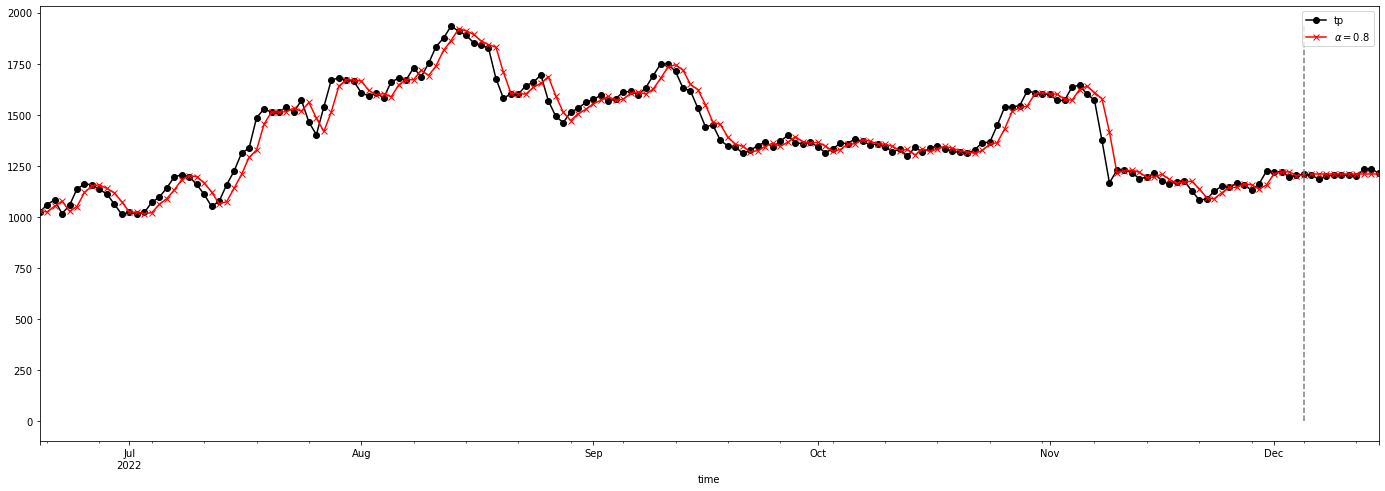

In [4]:
print('--- Simple Exponential Smoothing ---\n')
def ses(y, y_train, y_test, smoothing_level, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(24, 8))
    modello = SimpleExpSmoothing(y_train).fit(smoothing_level=smoothing_level)
    previsione = modello.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    previsione.plot(marker='x', color='red', legend=True)
    modello.fittedvalues.plot(marker='x', color='red')
    mse1 = ((previsione - y_test) ** 2).mean()
    print('Errore con livello di smussamento custom di {} = {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    plt.vlines(split_date, 0, max(candles.tp), color='gray', linestyle='--')
    plt.show()

ses(candles.tp, candles_train, candles_test, 0.8, predict_date)

### Holt Linear Trend

Espandendo il metodo SES, il metodo Holt aiuta a prevedere i dati delle serie temporali
che hanno un particolare trend al loro interno.
Oltre al parametro di livellamento del livello α introdotto con il metodo SES, il
metodo Holt aggiunge il parametro di livellamento del trend β.
Come per il parametro α, anche l'intervallo di β è compreso tra 0 e 1.

Il seguente codice di esempio contiene due diverse varianti all'interno del metodo Holt.
Entrambe le varianti hanno α=0.6, β=0.2 ma la prima è un modello additivo mentre
la seconda implementa un modello esponenziale.
Un modello esponenziale sarebbe appropriato per situazioni in cui l'aumento o la
diminuzione del segnale osservato inizia lentamente ma poi accelera rapidamente.

Rispetto al modello SES, Holt cattura maggiormente il trend sotteso dai dati.
Tuttavia il trend rilevato è spesso troppo accentuato rispetto al trend reale.

c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Errore modello lineare 57.2
errore modello esponenziale 56.96


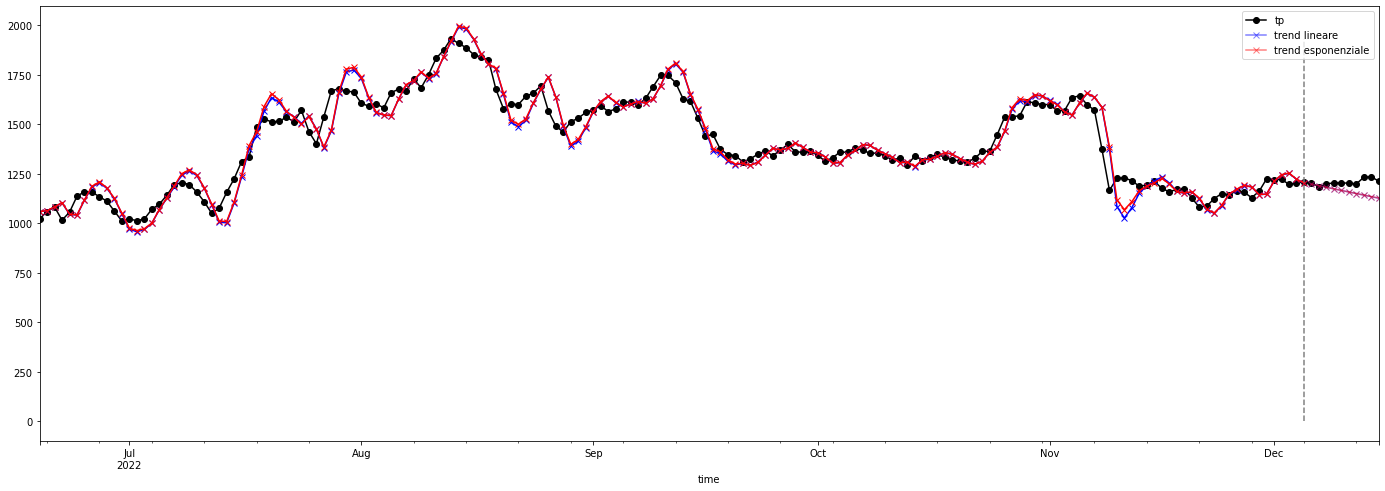

In [5]:
def holt(y, y_train, y_test, smoothing_level, smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(24, 8))

    hotl_add = Holt(y_train).fit(smoothing_level, smoothing_slope, optimized=False)
    predizioni_holt_add = hotl_add.forecast(predict_date).rename('trend lineare')
    mse1 = ((predizioni_holt_add - y_test) ** 2).mean()
    print('Errore modello lineare {}'.format(round(np.sqrt(mse1), 2)))

    holt_exp = Holt(y_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    predizioni_holt_exp = holt_exp.forecast(predict_date).rename('trend esponenziale')
    mse2 = ((predizioni_holt_exp - y_test) ** 2).mean()
    print('errore modello esponenziale {}'.format(round(np.sqrt(mse2), 2)))

    hotl_add.fittedvalues.plot(marker='x', color='blue')
    predizioni_holt_add.plot(color='blue', marker='x', legend=True, alpha=0.5)
    holt_exp.fittedvalues.plot(marker='x', color='red')
    predizioni_holt_exp.plot(color='red', marker='x', legend=True, alpha=0.5)
    plt.vlines(split_date, 0, max(candles.tp), color='gray', linestyle='--')
    plt.show()

holt(candles.tp, candles_train, candles_test, 0.5, 0.8, predict_date)

### Modello Holt-Winters

Il modello Holt-Winters estende il modello Holt per consentire la previsione su serie
temporali che presentano sia trend che stagionalità; utilizza un parametro di livellamento
della stagionalità chiamato γ.

Esistono due tipi generali di stagionalità: additiva e moltiplicativa.

**Additiva**: xt = Trend + Stagionale + Casuale    
I cambiamenti stagionali nei dati rimangono più o meno gli stessi nel tempo e non
fluttuano in relazione ai dati complessivi.

**Moltiplicativa**: xt = Trend * Stagionale * Casuale    
La variazione stagionale cambia in relazione alle variazioni complessive dei dati.
Quindi, se i dati sono in aumento, anche le differenze stagionali crescono in proporzione.

La libreria Python **statsmodels** fornisce una gamma di combinazioni di parametri basate
sui tipi di trend, di stagionalità e altre opzioni per eseguire trasformazioni Box-Cox (
trasformazioni di dati non su
distribuzione normale a dati che seguono una distribuzione normale).    
Per saperne di più:
* documentazione: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
* spiegazione dettagliata del modello: https://otexts.com/fpp2/holt-winters.html

c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


errore trend e stagionalità su un periodo di 2 e con trasformazione Box-Cox 14.08
errore trend e stagionalità con smorzamento su un periodo di 2 e con trasformazione Box-Cox 14.62


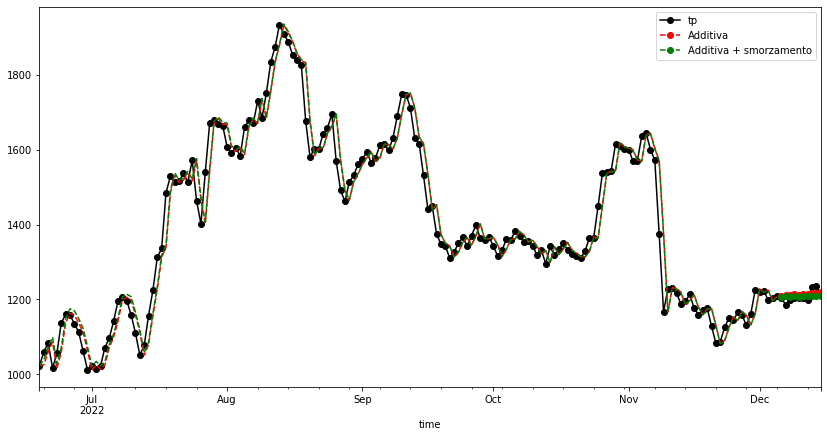

In [6]:
def holt_winters_with_add(y, y_train, y_test, seasonal_period, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    # Box-Cox
    # Una trasformazione di Box Cox è una trasformazione di variabili dipendenti non normali in una forma normale.
    # La normalità è un presupposto importante per molte tecniche statistiche; l'applicazione di un Box-Cox permette
    # di eseguire un numero più ampio di test e di utilizzare i dati trasformati con più tipologie di modelli.
    modello_additivo = ExponentialSmoothing(y_train, seasonal_periods=seasonal_period, trend='add', seasonal='add', use_boxcox=True).fit()
    predizioni_modello_additivo = modello_additivo.forecast(predict_date).rename('Additiva')
    mse1 = ((predizioni_modello_additivo - y_test) ** 2).mean()
    print('errore trend e stagionalità su un periodo di {} e con trasformazione Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    modello_additivo_con_smorzamento = ExponentialSmoothing(y_train, seasonal_periods=seasonal_period, trend='add', seasonal='add', damped_trend=True, use_boxcox=True).fit()
    predizioni_modello_additivo_con_smorzamento = modello_additivo_con_smorzamento.forecast(predict_date).rename('Additiva + smorzamento')
    mse2 = ((predizioni_modello_additivo_con_smorzamento - y_test) ** 2).mean()
    print('errore trend e stagionalità con smorzamento su un periodo di {} e con trasformazione Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))

    modello_additivo.fittedvalues.plot(style='--', color='red')
    predizioni_modello_additivo.plot(style='--', marker='o', color='red', legend=True)
    modello_additivo_con_smorzamento.fittedvalues.plot(style='--', color='green')
    predizioni_modello_additivo_con_smorzamento.plot(style='--', marker='o', color='green', legend=True)

    plt.show()

holt_winters_with_add(candles.tp, candles_train, candles_test, 2, predict_date)

c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\cloud\gitlab\fh_formazioneinterna\venvnew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


errore trend e stagionalità su un periodo di 2 e con trasformazione Box-Cox 14.07
errore trend e stagionalità con smorzamento su un periodo di 2 e con trasformazione Box-Cox 14.07


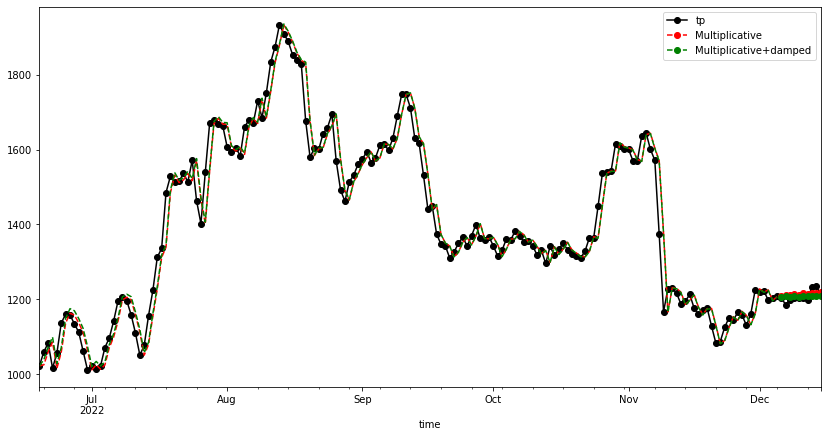

In [7]:
def holt_winters_with_mul(y, y_train, y_test, seasonal_period, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    fit3 = ExponentialSmoothing(y_train, seasonal_periods=seasonal_period, trend='add', seasonal='mul', use_boxcox=True).fit()
    fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
    mse3 = ((fcast3 - y_test) ** 2).mean()
    print('errore trend e stagionalità su un periodo di {} e con trasformazione Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))

    fit4 = ExponentialSmoothing(y_train, seasonal_periods=seasonal_period, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True).fit()
    fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
    mse4 = ((fcast3 - y_test) ** 2).mean()
    print('errore trend e stagionalità con smorzamento su un periodo di {} e con trasformazione Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))

    fit3.fittedvalues.plot(style='--', color='red')
    fcast3.plot(style='--', marker='o', color='red', legend=True)
    fit4.fittedvalues.plot(style='--', color='green')
    fcast4.plot(style='--', marker='o', color='green', legend=True)

    plt.show()

holt_winters_with_mul(candles.tp, candles_train, candles_test, 2, predict_date)